In [2]:
# ==== Configuration ====
import os

INPUT_DIR  = 'data'        # folder with your 6 images
OUTPUT_DIR = 'results/resumes_out'    # will be created if missing
REPORT_CSV = 'results/watermark_eval_report_qim.csv'

# Watermark parameters (tune invisibility vs robustness)
SECRET_KEY     = 'resume-watermark-secret-2025'   # PRNG seed for block selection
DCT_COEFF      = (1, 2)    # mid-frequency (row, col) in 8x8 DCT (avoid (0,0) DC)
QIM_STEP       = 10.0      # quantization step; larger → more robust but more visible
BLOCKS_PER_BIT = 16       # redundancy per bit; larger → more robust but slower
CHANNEL        = 'Y'       # embed in luma channel (Y in YCbCr)

# Robustness test settings
JPEG_QUALS     = [95, 85, 70, 50]
RESIZE_FACTORS = [0.90, 0.75, 0.50]
CROP_RATIOS    = [0.05, 0.10, 0.20]

os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Configured. INPUT_DIR=', INPUT_DIR)

Configured. INPUT_DIR= data


In [3]:
import numpy as np, math, io, json, uuid
from glob import glob
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

def list_images(folder, exts=('.png','.jpg','.jpeg','.bmp','.tif','.tiff')):
    files = []
    for ext in exts:
        files.extend(glob(os.path.join(folder, f'*{ext}')))
    return sorted(files)

def ensure_rgb(path):
    return Image.open(path).convert('RGB')

def to_ycbcr(img: Image.Image):
    ycbcr = img.convert('YCbCr')
    y, cb, cr = [np.array(ch, dtype=np.float32) for ch in ycbcr.split()]
    return y, cb, cr

def from_ycbcr(y, cb, cr):
    yimg = Image.fromarray(np.clip(y, 0, 255).astype(np.uint8))
    cbimg = Image.fromarray(np.clip(cb,0,255).astype(np.uint8))
    crimg = Image.fromarray(np.clip(cr,0,255).astype(np.uint8))
    return Image.merge('YCbCr', (yimg, cbimg, crimg)).convert('RGB')

def pad_to_multiple(img: Image.Image, m=8):
    w, h = img.size
    W = (w + m - 1)//m * m
    H = (h + m - 1)//m * m
    if (W, H) == (w, h):
        return img, (0,0)
    out = Image.new('RGB', (W,H))
    out.paste(img, (0,0))
    return out, (W-w, H-h)

def unpad(img: Image.Image, pad):
    dx, dy = pad
    if dx==0 and dy==0:
        return img
    w,h = img.size
    return img.crop((0,0,w-dx,h-dy))

# DCT helpers (8x8)
def dct2_8x8(block):
    return cv_dct(block)

def idct2_8x8(block):
    return cv_idct(block)

def cv_dct(block):
    # block: 8x8 float32
    import cv2
    return cv2.dct(block.astype(np.float32))

def cv_idct(block):
    import cv2
    return cv2.idct(block.astype(np.float32))

# QIM mapping: place value near centers based on bit parity of quantizer bin
def qim_embed_coeff(val: float, bit: int, step: float) -> float:
    sgn = 1.0 if val >= 0 else -1.0
    a = abs(val)
    q = math.floor(a / step)
    # push into sub-interval depending on target bit
    if (q % 2) != bit:
        a = (q + 1) * step + 0.25 * step
    else:
        a = (q + 0.5) * step
    return sgn * a

def qim_decode_coeff(val: float, step: float) -> int:
    a = abs(val)
    q = math.floor(a / step)
    return q % 2

# PRNG mapping: choose distinct 8x8 blocks per bit
def prng_indices_for_bits(seed: int, H: int, W: int, blocks_per_bit: int, nbits: int):
    rng = np.random.default_rng(seed)
    Bh, Bw = H//8, W//8
    total = Bh * Bw
    if blocks_per_bit * nbits > total:
        raise ValueError('Not enough 8x8 blocks for the requested redundancy; use smaller BLOCKS_PER_BIT or larger image.')
    # sample without replacement globally, then slice per bit for disjointness
    idx = rng.choice(total, size=blocks_per_bit*nbits, replace=False)
    mapping = {}
    for b in range(nbits):
        chunk = idx[b*blocks_per_bit:(b+1)*blocks_per_bit]
        coords = [(i//Bw, i%Bw) for i in chunk]
        mapping[b] = coords
    return mapping

def bits_to_hex(bits):
    s = ''.join(str(int(b)) for b in bits)
    return f"{int(s,2):016x}"  # fixed 64-bit hex

def hex_to_bits(hex16):
    x = int(hex16, 16)
    b = [(x >> i) & 1 for i in range(63,-1,-1)]
    return np.array(b, dtype=np.uint8)

def gen_uuid64():
    return f"{(uuid.uuid4().int & ((1<<64)-1)):016x}"

In [4]:
def embed_uuid_qim(img: Image.Image,
                   uuid_hex: str,
                   key: str,
                   dct_coeff=(1,2),
                   step=10.0,
                   blocks_per_bit=128,
                   channel='Y'):
    # Prepare planes
    padded, pad = pad_to_multiple(img, 8)
    y, cb, cr = to_ycbcr(padded)
    H, W = y.shape

    bits = hex_to_bits(uuid_hex)  # 64 bits
    seed = (hash((key, H, W)) & 0x7fffffff)
    mapping = prng_indices_for_bits(seed, H, W, blocks_per_bit, nbits=len(bits))

    y_mod = y.copy()
    r, c = dct_coeff

    for bit_idx, coords in mapping.items():
        b = int(bits[bit_idx])
        for (br, bc) in coords:
            blk = y_mod[br*8:(br+1)*8, bc*8:(bc+1)*8]
            coeff = dct2_8x8(blk - 128.0)
            coeff[r, c] = qim_embed_coeff(coeff[r, c], b, step)
            y_mod[br*8:(br+1)*8, bc*8:(bc+1)*8] = idct2_8x8(coeff) + 128.0

    out = from_ycbcr(y_mod, cb, cr)
    out = unpad(out, pad)
    return out

def decode_uuid_qim(img: Image.Image,
                    key: str,
                    dct_coeff=(1,2),
                    step=10.0,
                    blocks_per_bit=128,
                    channel='Y'):
    padded, pad = pad_to_multiple(img, 8)
    y, cb, cr = to_ycbcr(padded)
    H, W = y.shape
    seed = (hash((key, H, W)) & 0x7fffffff)
    mapping = prng_indices_for_bits(seed, H, W, blocks_per_bit, nbits=64)
    r, c = dct_coeff

    decoded_bits = []
    for bit_idx in range(64):
        votes = []
        for (br, bc) in mapping[bit_idx]:
            blk = y[br*8:(br+1)*8, bc*8:(bc+1)*8]
            coeff = dct2_8x8(blk - 128.0)
            votes.append(qim_decode_coeff(coeff[r, c], step))
        ones = sum(votes)
        zeros = len(votes) - ones
        decoded_bits.append(1 if ones >= zeros else 0)
    bits = np.array(decoded_bits, dtype=np.uint8)
    return bits_to_hex(bits), bits

def bits_to_hex(bits):
    s = ''.join('1' if b else '0' for b in bits)
    return f"{int(s,2):016x}"

In [5]:
def apply_jpeg(img, q):
    buf = io.BytesIO()
    img.save(buf, format='JPEG', quality=q, subsampling=1, optimize=True)
    buf.seek(0)
    return Image.open(buf).convert('RGB')

def apply_resize(img, fct):
    w,h = img.size
    small = img.resize((int(w*fct), int(h*fct)), Image.BICUBIC)
    return small.resize((w,h), Image.BICUBIC)

def apply_crop(img, ratio):
    w,h = img.size
    dx,dy = int(w*ratio), int(h*ratio)
    return img.crop((dx, dy, w-dx, h-dy)).resize((w,h), Image.BICUBIC)

def psnr(imgA: Image.Image, imgB: Image.Image):
    a = np.asarray(imgA, dtype=np.float32)
    b = np.asarray(imgB, dtype=np.float32)
    mse = np.mean((a-b)**2)
    if mse == 0:
        return 99.0
    return 20 * math.log10(255.0 / math.sqrt(mse))

[EMBED] data\resume1_clean.png -> results/resumes_out\resume1_clean__wm.png  UUID=9e6c1752dbebd79f  PSNR=53.26 dB
[EMBED] data\resume2_clean.png -> results/resumes_out\resume2_clean__wm.png  UUID=88db6d374b624979  PSNR=57.91 dB
[EMBED] data\resume3_clean.png -> results/resumes_out\resume3_clean__wm.png  UUID=a7610f14e717b4f0  PSNR=47.06 dB
[EMBED] data\resume4_clean.png -> results/resumes_out\resume4_clean__wm.png  UUID=99e9655cb1639ede  PSNR=45.97 dB
[EMBED] data\resume5_clean.png -> results/resumes_out\resume5_clean__wm.png  UUID=bb42a6c44a9dfc58  PSNR=52.39 dB
[EMBED] data\resume6_clean.png -> results/resumes_out\resume6_clean__wm.png  UUID=94b0667b3f7f3f56  PSNR=48.66 dB
[REPORT] Wrote: results/watermark_eval_report_qim.csv


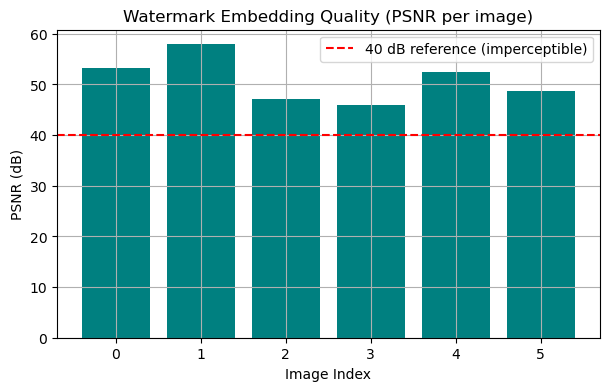

In [8]:
images = list_images(INPUT_DIR)
if not images:
    raise SystemExit(f'No images found in {INPUT_DIR}. Place your resumes there and rerun.')

manifest = {}
for path in images:
    img = ensure_rgb(path)
    uid = gen_uuid64()
    wm = embed_uuid_qim(img, uid, key=SECRET_KEY, dct_coeff=DCT_COEFF, step=QIM_STEP,
                        blocks_per_bit=BLOCKS_PER_BIT, channel=CHANNEL)
    base = os.path.splitext(os.path.basename(path))[0]
    out_path = os.path.join(OUTPUT_DIR, f"{base}__wm.png")
    wm.save(out_path, quality=95)
    p = psnr(img, wm)
    print(f"[EMBED] {path} -> {out_path}  UUID={uid}  PSNR={p:.2f} dB")
    manifest[out_path] = {'src': path, 'uuid': uid, 'psnr': p}

with open(os.path.join(OUTPUT_DIR, 'watermark_manifest_qim.json'), 'w') as f:
    json.dump(manifest, f, indent=2)

rows = []
def add_row(file, variant, param, truth, decoded, ber, ok):
    rows.append({'file': file, 'variant': variant, 'param': param,
                 'truth': truth, 'decoded': decoded,
                 'ber': ber, 'match': ok})

for wm_path, info in manifest.items():
    truth_hex = info['uuid']
    orig_img = Image.open(wm_path).convert('RGB')
    # Original
    dec_hex, dec_bits = decode_uuid_qim(orig_img, key=SECRET_KEY, dct_coeff=DCT_COEFF,
                                        step=QIM_STEP, blocks_per_bit=BLOCKS_PER_BIT, channel=CHANNEL)
    truth_bits = hex_to_bits(truth_hex)
    ber = float(np.mean(dec_bits != truth_bits))
    add_row(wm_path, 'original', '', truth_hex, dec_hex, ber, dec_hex == truth_hex)

    # JPEG
    for q in JPEG_QUALS:
        imj = apply_jpeg(orig_img, q)
        outj = os.path.join(OUTPUT_DIR, os.path.basename(wm_path)[:-4] + f'__jpeg{q}.jpg')
        imj.save(outj, quality=q)
        dec_hex, dec_bits = decode_uuid_qim(imj, key=SECRET_KEY, dct_coeff=DCT_COEFF,
                                            step=QIM_STEP, blocks_per_bit=BLOCKS_PER_BIT, channel=CHANNEL)
        ber = float(np.mean(dec_bits != truth_bits))
        add_row(outj, 'jpeg', f"{q:.2f}", truth_hex, dec_hex, ber, dec_hex == truth_hex)

    # Resize
    for fct in RESIZE_FACTORS:
        imr = apply_resize(orig_img, fct)
        outr = os.path.join(OUTPUT_DIR, os.path.basename(wm_path)[:-4] + f'__resize{int(fct*100)}.png')
        imr.save(outr)
        dec_hex, dec_bits = decode_uuid_qim(imr, key=SECRET_KEY, dct_coeff=DCT_COEFF,
                                            step=QIM_STEP, blocks_per_bit=BLOCKS_PER_BIT, channel=CHANNEL)
        ber = float(np.mean(dec_bits != truth_bits))
        add_row(outr, 'resize', f"{fct:.2f}", truth_hex, dec_hex, ber, dec_hex == truth_hex)

    # Crop
    for cr in CROP_RATIOS:
        imc = apply_crop(orig_img, cr)
        outc = os.path.join(OUTPUT_DIR, os.path.basename(wm_path)[:-4] + f'__crop{int(cr*100)}.png')
        imc.save(outc)
        dec_hex, dec_bits = decode_uuid_qim(imc, key=SECRET_KEY, dct_coeff=DCT_COEFF,
                                            step=QIM_STEP, blocks_per_bit=BLOCKS_PER_BIT, channel=CHANNEL)
        ber = float(np.mean(dec_bits != truth_bits))
        add_row(outc, 'crop', f"{cr:.2f}", truth_hex, dec_hex, ber, dec_hex == truth_hex)

df = pd.DataFrame(rows)
df.to_csv(REPORT_CSV, index=False)
print('[REPORT] Wrote:', REPORT_CSV)
df.head()

plt.figure(figsize=(7,4))
psnrs = [m['psnr'] for m in manifest.values()]
plt.bar(range(len(psnrs)), psnrs, color='teal')
plt.axhline(40, color='red', linestyle='--', label='40 dB reference (imperceptible)')
plt.title('Watermark Embedding Quality (PSNR per image)')
plt.xlabel('Image Index'); plt.ylabel('PSNR (dB)')
plt.legend(); plt.grid(True)
plt.show()

In [9]:
summary = []
for variant in ['jpeg','resize','crop']:
    g = df[df['variant']==variant]
    for param in sorted(g['param'].unique(), key=lambda x: float(x) if x!='' else -1):
        sub = g[g['param']==param]
        success = sub['match'].mean()*100.0
        avg_ber = sub['ber'].mean()
        summary.append({'variant':variant, 'param':param, 'success_rate_%':success, 'avg_BER':avg_ber})
summary_df = pd.DataFrame(summary)
summary_df

,variant,param,success_rate_%,avg_BER
0,jpeg,50.00,100.000000,0.000000
1,jpeg,70.00,0.000000,0.523438
2,jpeg,85.00,0.000000,0.312500
3,jpeg,95.00,16.666667,0.281250
4,resize,0.50,0.000000,0.546875
5,resize,0.75,0.000000,0.429688
6,resize,0.90,0.000000,0.408854
7,crop,0.05,0.000000,0.549479
8,crop,0.10,0.000000,0.552083
9,crop,0.20,0.000000,0.549479


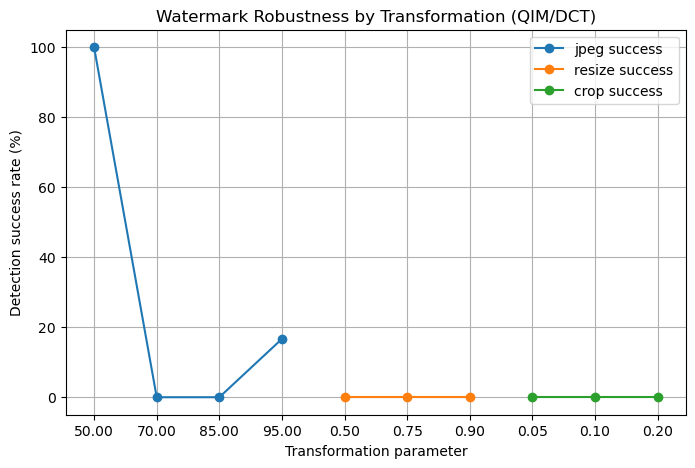

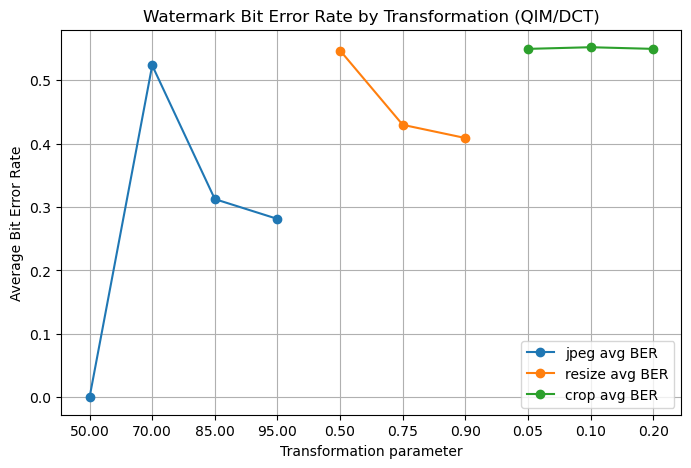

In [11]:
plt.figure(figsize=(8,5))
for variant in ['jpeg','resize','crop']:
    sub = summary_df[summary_df['variant']==variant]
    plt.plot(sub['param'], sub['success_rate_%'], marker='o', label=f'{variant} success')
plt.xlabel('Transformation parameter'); plt.ylabel('Detection success rate (%)')
plt.title('Watermark Robustness by Transformation (QIM/DCT)')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
for variant in ['jpeg','resize','crop']:
    sub = summary_df[summary_df['variant']==variant]
    plt.plot(sub['param'], sub['avg_BER'], marker='o', label=f'{variant} avg BER')
plt.xlabel('Transformation parameter'); plt.ylabel('Average Bit Error Rate')
plt.title('Watermark Bit Error Rate by Transformation (QIM/DCT)')
plt.legend(); plt.grid(True); plt.show()